In [1]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xf ./VOCtrainval_06-Nov-2007.tar
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

File ‘VOCtrainval_06-Nov-2007.tar’ already there; not retrieving.



In [2]:
#prepare dataset
images = os.listdir('./VOCdevkit/VOC2007/JPEGImages')

imgdataset = []
for filename in images:
    img = Image.open('./VOCdevkit/VOC2007/JPEGImages/'+ filename )
    img.load()
    data = np.asarray( img, dtype="uint8")
    if data.shape[0]>320 and data.shape[1]>320:
        imgdataset.append(data[0:320,0:320,:])
    
print('images count', len(imgdataset))

images count 4725


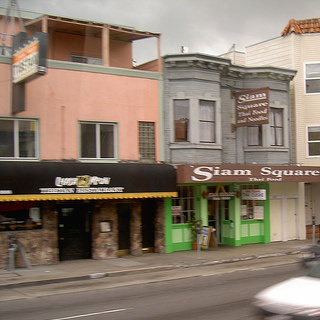

In [3]:
display(Image.fromarray(imgdataset[752]))

In [10]:
#download and convert to vae
!wget -nc https://huggingface.co/graphnull/vae_onnx/resolve/main/vae_decoder.onnx?download=true -O vae_decoder.onnx
!wget -nc https://huggingface.co/graphnull/vae_onnx/resolve/main/vae_encoder.onnx?download=true -O vae_encoder.onnx
import onnxruntime as ort

providers = ['CUDAExecutionProvider','CPUExecutionProvider']

vae_encoder = ort.InferenceSession('../vae_encoder.onnx', providers=providers)

File ‘vae_encoder.onnx’ already there; not retrieving.


In [4]:
if os.path.isfile('dataset.npy'):
    dataset = np.load('dataset.npy')

    dataset = torch.from_numpy(dataset).to(device)
else:
    dataset = []

    #for data in imgdataset:
    for i in tqdm(range(len(imgdataset))):
        time.sleep(0.1)
        data = imgdataset[i]
        normalized = (np.expand_dims(data.transpose((2,0,1)).astype(np.single), axis=0)/ 255.0) * 2.0 - 1.0

        form = np.zeros((1, 3, 512,512)).astype(np.single)
        form[:,:,0:320,0:320] = normalized

        dataset.append(vae_encoder.run(None, {"input": form })[0][0,:,0:40,0:40])
    dataset = np.stack(dataset, axis=0)
    dataset = torch.from_numpy(dataset).to(device)
    with open('dataset.npy', 'wb') as f:
        np.save(f, dataset)
print('dataset', dataset.shape)

dataset torch.Size([4725, 4, 40, 40])


In [5]:
from tqdm import tqdm
outdataset = []
outdataset2x = []
outdataset4x = []

#for data in imgdataset:
for i in tqdm(range(len(imgdataset))):
    
    data = imgdataset[i]
    normalized = ((data.transpose((2,0,1)).astype(np.single)) / 255.0) * 2.0 - 1.0
    scaled2x = (normalized[:,::2,::2]+normalized[:,1::2,::2]+normalized[:,::2,1::2]+normalized[:,1::2,1::2])/4
    scaled4x = (scaled2x[:,::2,::2]+scaled2x[:,1::2,::2]+scaled2x[:,::2,1::2]+scaled2x[:,1::2,1::2])/4
    scaled8x = (scaled4x[:,::2,::2]+scaled4x[:,1::2,::2]+scaled4x[:,::2,1::2]+scaled4x[:,1::2,1::2])/4
    outdataset.append(scaled8x)
    outdataset2x.append(scaled4x)
    outdataset4x.append(scaled2x)
    
outdataset = np.stack(outdataset, axis=0)
with open('outdataset.npy', 'wb') as f:
    np.save(f, outdataset)
outdataset = torch.from_numpy(outdataset).to(device)
print('dataset', outdataset.shape)

outdataset2x = np.stack(outdataset2x, axis=0)
with open('outdataset2x.npy', 'wb') as f:
    np.save(f, outdataset2x)
outdataset2x = torch.from_numpy(outdataset2x).to(device)
print('outdataset2x', outdataset2x.shape)

outdataset4x = np.stack(outdataset4x, axis=0)
with open('outdataset4x.npy', 'wb') as f:
    np.save(f, outdataset4x)
outdataset4x = torch.from_numpy(outdataset4x).to(device)
print('outdataset4x', outdataset4x.shape)

100%|██████████| 4725/4725 [00:03<00:00, 1255.48it/s]


dataset torch.Size([4725, 3, 40, 40])
outdataset2x torch.Size([4725, 3, 80, 80])
outdataset4x torch.Size([4725, 3, 160, 160])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.cv1 = nn.Conv2d(4, 8, 3, padding="same")
        self.cv2 = nn.Conv2d(8, 16, 3, padding="same")
        self.cv3 = nn.ConvTranspose2d(16, 16, 2,stride=2,padding=0, output_padding=0)
        self.cv4 = nn.Conv2d(16, 32, 3, padding="same")
        self.cv5 = nn.Conv2d(32, 64, 3, padding="same")
        self.cv6 = nn.ConvTranspose2d(64, 64, 2,stride=2,padding=0, output_padding=0)
        self.cv7 = nn.Conv2d(64, 64, 3, padding="same")
        self.cv8 = nn.Conv2d(64, 64, 3, padding="same")
        self.cv9 = nn.ConvTranspose2d(64, 64, 2,stride=2,padding=0, output_padding=0)
        self.cv10 = nn.Conv2d(64, 64, 3, padding="same")
        self.cv11 = nn.Conv2d(64, 3, 3, padding="same")
        #self.norm = nn.LayerNorm(4, eps=1e-5)
        #self.norm2 = nn.LayerNorm(32, eps=1e-5)
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.c2v1 = nn.Conv2d(4, 8, 3, padding="same")
        self.c2v2 = nn.Conv2d(8, 16, 3, padding="same")
        self.c2v3 = nn.Conv2d(16, 32, 3, padding="same")
        self.c2v4 = nn.Conv2d(32, 3, 3, padding="same")
        
        self.c3v1 = nn.Conv2d(4, 8, 3, padding="same")
        self.c3v2 = nn.Conv2d(8, 16, 3, padding="same")
        self.c3v3 = nn.ConvTranspose2d(16, 16, 2,stride=2,padding=0, output_padding=0)
        self.c3v4 = nn.Conv2d(16, 32, 3, padding="same")
        self.c3v5 = nn.Conv2d(32, 3, 3, padding="same")

        self.c4v1 = nn.Conv2d(4, 8, 3, padding="same")
        self.c4v2 = nn.Conv2d(8, 16, 3, padding="same")
        self.c4v3 = nn.ConvTranspose2d(16, 16, 2,stride=2,padding=0, output_padding=0)
        self.c4v4 = nn.Conv2d(16, 32, 3, padding="same")
        self.c4v5 = nn.Conv2d(32, 64, 3, padding="same")
        self.c4v6 = nn.ConvTranspose2d(64, 64, 2,stride=2,padding=0, output_padding=0)
        self.c4v7 = nn.Conv2d(64, 64, 3, padding="same")
        self.c4v8 = nn.Conv2d(64, 3, 3, padding="same")
        self.d1 = nn.Dropout(p=0.1)
        self.d2 = nn.Dropout(p=0.1)
        self.d3 = nn.Dropout(p=0.1)
        self.d4 = nn.Dropout(p=0.1)
        #self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
        #self.fc5 = nn.Linear(embed_size*4, embed_size*1)
        #self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):

        start = (x.transpose(1,2).transpose(2,3)).transpose(3,2).transpose(2,1)
        
        x = self.lrelu(self.cv1(start))
        x = self.lrelu(self.cv2(x))
        x = self.lrelu(self.cv3(x))
        x = self.lrelu(self.cv4(x))
        x = self.lrelu(self.cv5(x))
        x = self.d1(x)
        x = self.lrelu(self.cv6(x))
        x = self.lrelu(self.cv7(x))
        x = self.lrelu(self.cv8(x))
        x = self.lrelu(self.cv9(x))
        x = self.lrelu(self.cv10(x))
        freq8x = self.cv11(x)
        
        x = self.lrelu(self.c4v1(start))
        x = self.lrelu(self.c4v2(x))
        x = self.lrelu(self.c4v3(x))
        x = self.lrelu(self.c4v4(x))
        x = self.d2(x)
        x = self.lrelu(self.c4v5(x))
        x = self.lrelu(self.c4v6(x))
        x = self.lrelu(self.c4v7(x))
        freq4x = self.c4v8(x)
        
        x = self.lrelu(self.c3v1(start))
        x = self.lrelu(self.c3v2(x))
        x = self.d3(x)
        x = self.lrelu(self.c3v3(x))
        x = self.lrelu(self.c3v4(x))
        freq2x = self.c3v5(x)
        
        x = self.lrelu(self.c2v1(start))
        x = self.lrelu(self.c2v2(x))
        x = self.d4(x)
        x = self.lrelu(self.c2v3(x))
        base = self.c2v4(x)
        
        return (base, freq2x, freq4x, freq8x)

    
model = Net()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
globloss=0.5
print(model)
upscale2x = nn.Upsample(scale_factor=2, mode='bilinear')
upscale4x = nn.Upsample(scale_factor=4, mode='bilinear')
upscale8x = nn.Upsample(scale_factor=8, mode='bilinear')
iterations = 0

Net(
  (cv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv3): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (cv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv6): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv9): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv11): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (c2v1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v3): Conv2d(16, 3

In [7]:
checkpoint = torch.load('./checkpoint.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
iterations = checkpoint['iterations']
globloss = checkpoint['loss']
model.train()

Net(
  (cv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv3): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (cv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv6): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv9): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv11): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (c2v1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v3): Conv2d(16, 3

In [75]:
validation_files = ['./example.jpg', './example2.jpg']
def getValidationLoss():
    loss = 0
    for file_path in validation_files:
        img = Image.open(file_path )
        img.load()
        data = np.asarray( img, dtype="uint8")
        normalized = (np.expand_dims(data.transpose((2,0,1)).astype(np.single), axis=0)[:,:,:512,:512]/ 255.0) * 2.0 - 1.0
        latent = vae_encoder.run(None, {"input": normalized })[0]

        with torch.no_grad():
            tlatent = torch.from_numpy(latent ).to(device)
            base, freq2x, freq4x, freq8x = model(tlatent)
            decoded = (upscale8x(base)+upscale4x(freq2x)+freq8x)[0].detach().cpu().clamp(-1.0,1.0).numpy()
            loss+= np.sqrt(((decoded[:,8:-8,8:-8]-normalized[:,:,8:-8,8:-8])**2).mean())
            #print(base.shape)
            #display(Image.fromarray(( (upscale8x(base)+upscale4x(freq2x)+freq8x)[0].detach().cpu().clamp(-1.0,1.0).numpy().transpose(1,2,0)*127+127).astype(np.uint8)))
    return loss/len(validation_files)
batch_size = 32
for e in range(1000):
  valloss = getValidationLoss()
  pbar =  tqdm(range(40))
  for i in pbar:
    random_ids = np.random.randint(dataset.shape[0], size=batch_size)
    inp = dataset[random_ids,:]
    out2x = outdataset4x[random_ids,:]
    out4x = outdataset2x[random_ids,:]
    out8x = outdataset[random_ids,:]
    
    out = torch.from_numpy(np.stack(np.array(imgdataset)[random_ids.astype(int)], axis=0).transpose((0,3,1,2)).astype(np.single) ).to(device)
    out= ((out) / 255.0) * 2.0 - 1.0
    optimizer.zero_grad()
    losses = []

    (base, freq2x, freq4x, freq8x) = model(inp)
    
    loss = ((upscale8x(base)+upscale4x(freq2x)+upscale2x(freq4x)+freq8x)[:,:,8:-8,8:-8]-out[:,:,8:-8,8:-8]).pow(2).mean().sqrt()
    globloss = loss.detach().cpu()*0.1+globloss*0.9
    pbar.set_description("Processing %f %i %f" % (globloss,iterations, valloss))
    loss = (loss+((upscale4x(base)+upscale2x(freq2x)+freq4x)[:,:,4:-4,4:-4]-out2x[:,:,4:-4,4:-4]).pow(2).mean().sqrt())
    loss = (loss+((upscale2x(base)+freq2x)[:,:,2:-2,2:-2]-out4x[:,:,2:-2,2:-2]).pow(2).mean().sqrt())
    loss = (loss+(base[:,:,1:-1,1:-1]-out8x[:,:,1:-1,1:-1]).pow(2).mean().sqrt())
    loss = loss/4.0
    #(base[:,:,1:-1,1:-1]-out8x[:,:,1:-1,1:-1]).pow(2).mean().sqrt()+\
    #    (freq2x[:,:,2:-2,2:-2]-(out-upscale2x(out2x))[:,:,2:-2,2:-2]).pow(2).mean().sqrt()+\
    #    (freq8x[:,:,8:-8,8:-8]-(out-upscale8x(out8x))[:,:,8:-8,8:-8]).pow(2).mean().sqrt()
    iterations+=1
    loss.backward()
    optimizer.step()
    if i%200==0:
        time.sleep(0.01)

Processing 0.155520 12869 0.136786:  15%|█▌        | 6/40 [00:05<00:32,  1.06it/s]


KeyboardInterrupt: 

torch.Size([1, 3, 320, 320]) torch.Size([1, 3, 320, 320]) torch.Size([1, 3, 320, 320])


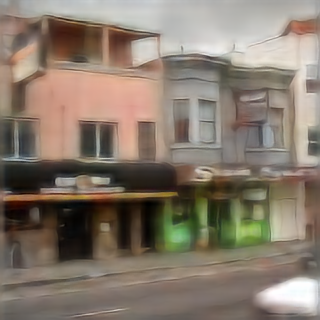

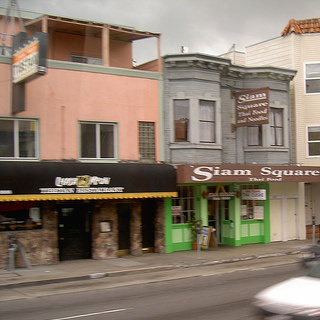

Net(
  (cv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv3): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (cv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv6): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv9): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv11): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (c2v1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v3): Conv2d(16, 3

In [87]:
model.eval()
with torch.no_grad():
    base, freq2x, freq4x, freq8x = model(dataset[752:753])
    print(upscale8x(base).shape,upscale4x(freq2x).shape,freq8x.shape)
    display(Image.fromarray(( (upscale8x(base)+upscale4x(freq2x)+freq8x)[0].detach().cpu().clamp(-1.0,1.0).numpy().transpose(1,2,0)*127+127).astype(np.uint8))
           .resize((320, 320), Image.Resampling.LANCZOS))
    display(Image.fromarray((imgdataset[752]).astype(np.uint8))
           .resize((320, 320), Image.Resampling.LANCZOS))
model.train()

In [86]:
torch.save({
    'model':model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': globloss,
    'iterations':iterations,
           }, f'./checkpoints/checkpoint_{iterations}_{getValidationLoss():0.3f}.pt')

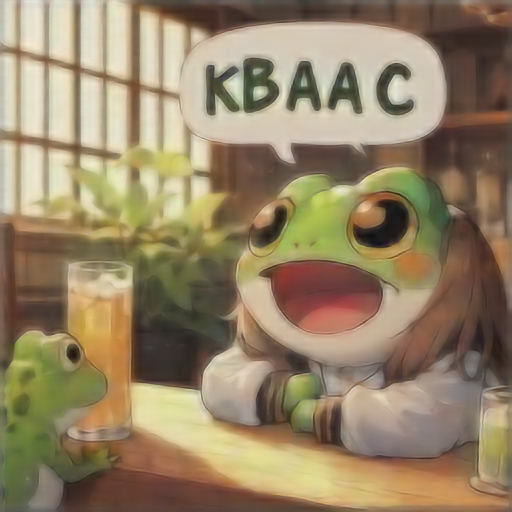

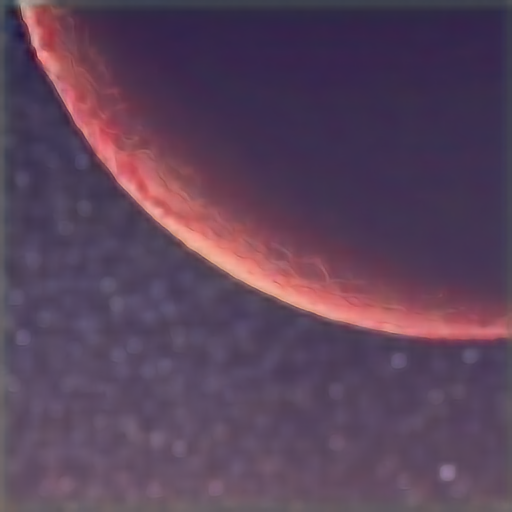

Net(
  (cv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv3): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (cv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv6): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv9): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (cv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cv11): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (c2v1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2v3): Conv2d(16, 3

In [88]:
model.eval()
img = Image.open('./example.jpg' )
img.load()
data = np.asarray( img, dtype="uint8")
normalized = (np.expand_dims(data.transpose((2,0,1)).astype(np.single), axis=0)[:,:,:512,:512]/ 255.0) * 2.0 - 1.0
latent = vae_encoder.run(None, {"input": normalized })[0]
with torch.no_grad():
    tlatent = torch.from_numpy(latent ).to(device)
    base, freq2x, freq4x, freq8x = model(tlatent)
    display(Image.fromarray(( (upscale8x(base)+upscale4x(freq2x)+freq8x)[0].detach().cpu().clamp(-1.0,1.0).numpy().transpose(1,2,0)*127+127).astype(np.uint8)))
    
    
img = Image.open('./example2.jpg' )
img.load()
data = np.asarray( img, dtype="uint8")
normalized = (np.expand_dims(data.transpose((2,0,1)).astype(np.single), axis=0)[:,:,:512,:512]/ 255.0) * 2.0 - 1.0
latent = vae_encoder.run(None, {"input": normalized })[0]
with torch.no_grad():
    tlatent = torch.from_numpy(latent ).to(device)
    base, freq2x, freq4x, freq8x = model(tlatent)
    display(Image.fromarray(( (upscale8x(base)+upscale4x(freq2x)+freq8x)[0].detach().cpu().clamp(-1.0,1.0).numpy().transpose(1,2,0)*127+127).astype(np.uint8)))
model.train()

In [92]:
!pip install onnx

  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/fe/33/a84bb5164f1462edd10d15516d5b12fee8a5e7d94b73829c7d32545cdc22/onnx-1.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 11.4 MB/s eta 0:00:0000:0100:01


In [93]:
# Input to the model
batch_size = 1
height = 64
width = 64
x = torch.randn(batch_size, 4, height, width).to(device)


# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "VAEpreview.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['latent'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'latent' : {0 : 'batch_size', 2:'height', 3:'width'},    # variable length axes
                                'output' : {0 : 'batch_size', 2:'height', 3:'width'}})